# Prediction Task:
## _Predict bike rental demand as a function of suitable features available in or derived from the data sets_

## Libraries and styles

In [78]:
# importing all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from haversine import haversine, Unit

In [79]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
%config IPCompleter.greedy=True

## Read data

In [80]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["time"] = pd.to_datetime(trip_data["time"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

In [81]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

***
## Data for Prediction Task

### Prepare data
Since we have data sets with single entries (trips) at one specific point of time, it does not make sense to take a value from the single entries as a target (since there is no "rental demand" associated with a single trip). Rather, we have to group the trips by a time unit, e.g. hour or day, and aggregate the number of trips per time unit, so there is a target associated with our data that can be predicted.

In [82]:
dataBr.head()

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,...,fleetsize_weekly,fleetsize_dayly,fleetsize_monthly,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain
0,0,2019-04-21,2021-02-04 17:34:00,20507,bremen,00:13:00,53.078923,8.884911,53.078711,8.899906,...,331,163,395,1.001900,0.216667,4.624155,2019-04-21 18:00:00,20.4,2.0,0.0
1,1,2019-05-23,2021-02-04 15:33:00,20507,bremen,00:07:00,53.078923,8.884911,53.078004,8.876828,...,310,172,373,0.549476,0.116667,4.709793,2019-05-23 16:00:00,20.7,2.4,0.0
2,2,2019-06-14,2021-02-04 22:30:00,20507,bremen,00:08:00,53.078923,8.884911,53.074731,8.876003,...,304,204,342,0.755886,0.133333,5.669146,2019-06-14 22:00:00,19.6,4.4,0.0
3,3,2019-06-16,2021-02-04 10:00:00,20507,bremen,02:02:00,53.074731,8.876003,53.078923,8.884911,...,304,184,342,0.755886,2.033333,0.371747,2019-06-16 10:00:00,21.6,3.0,0.0
4,4,2019-06-16,2021-02-04 12:55:00,20507,bremen,02:23:00,53.078923,8.884911,53.076236,8.891322,...,304,184,342,0.522213,2.383333,0.219110,2019-06-16 13:00:00,21.8,4.4,0.0


#### add distance from city center

In [83]:
city1 = "Bremen"
city2 = "Duesseldorf"
start_date = "2019-02-01 00:00:00"
end_date = "2019-06-30 23:59:00"
startDate = datetime.fromisoformat(start_date)
endDate = datetime.fromisoformat(end_date)

In [84]:
# coordinates of city center as [lat, lng]
br_center = [53.078893247451994, 8.8027747491885]
du_center = [51.226815497281706, 6.773786392066722]

In [85]:
dataBr["distance_from_center_start"] = dataBr.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataBr["distance_from_center_end"] = dataBr.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_start"] = dataDu.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_end"] = dataDu.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 

#### Drop columns that are irrelevant for predicting daily values
E.g. IDs

In [86]:
dBr = dataBr.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)
dDu = dataDu.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)

#### main processing function

In [104]:
def process_data_for_city(data, city, start_date, end_date, group):
    '''
    Processes given data and aggregates certain columns per hour or day (group param) for a given city in a given time window
    
    :param data: the dataFrame of a given city
    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    :param group: a string, either "hour" or "day"
    '''

    # sorting of data
    dat = data.sort_values(by=['datetime_start'], axis=0)

    # select rows in the given time window
    dat_time_framed = dat.loc[(dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)]
        
    # Group data in the given time window by month, day and hours to get to specific hourly level
    # and aggregate on several columns
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    grouping = [times.month, times.day, times.hour] if group == "hour" else  [times.month, times.day]
    dat_time_framed["inner"] = dat_time_framed["distance_from_center_start"] <= 1
    groupedBy = dat_time_framed.groupby(grouping).agg(trips_per_time=("datetime_start","count"), avg_temp=("temp","mean"), avg_wind=("wind","mean"), avg_rain=("rain","mean"), avg_distance=("distance","mean"), innerCityMean=("inner","mean"),avg_dist_from_center_start=("distance_from_center_start","mean"), avg_dist_from_center_end=("distance_from_center_end","mean"))

    # reset index to get the groupedBy values back as columns
    groupedBy.index.rename(["month", "day", "hour"] if group == "hour" else ["month","day"], inplace=True)
    groupedBy.reset_index(inplace=True)
    
    # generate string date column
    groupedBy["date"] = "2019-" + groupedBy["month"].astype(str) + "-" +  groupedBy["day"].astype(str) + " 00:00:00"

    # generate datetime column for checking of weekdays and remove string date column
    groupedBy["datetime"] = [pd.to_datetime(d) for d in groupedBy.date]
    groupedBy.drop(["date"], axis=1, inplace=True)

    # generate weekday column for later use
    groupedBy["weekday"] = [dt.weekday() for dt in groupedBy.datetime]
    groupedBy.drop(["datetime"], axis=1, inplace=True)

    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedBy["is_weekday"] = groupedBy["weekday"] <=4
    groupedBy.drop(["weekday"], axis=1, inplace=True)
    
    return groupedBy

In [88]:
TIME_FRAME="day"

#### prepared data:

In [105]:
br = process_data_for_city(dBr, city1, startDate, endDate, TIME_FRAME)
du = process_data_for_city(dDu, city2, startDate, endDate, TIME_FRAME) 

In [201]:
br.head()

,month,day,trips_per_time,avg_temp,avg_wind,avg_rain,avg_distance,innerCityMean,avg_dist_from_center_start,avg_dist_from_center_end,is_weekday
0,2,1,197,0.060914,4.290863,0.0,1.524199,0.411168,1.875367,1.968714,True
1,2,2,118,0.450847,3.150000,0.0,1.489424,0.271186,1.774694,1.954111,False
2,2,3,139,1.653957,3.487050,0.0,1.590335,0.294964,1.724617,1.780380,False
3,2,4,162,2.485802,5.846296,0.0,1.742222,0.308642,2.154845,2.272686,True
4,2,5,227,3.875330,4.803965,0.0,1.587274,0.387665,1.899668,1.835590,True


***
## Correlation Analysis

The goal is to select those features (from the set of all features) that are optimally least correlated with each other and highly correlated with the target. We analyzed the correlation between features and the correlation of features with the target value. 

As a guideline one could take a boundary correlation value of 0.3 or -0.3 to detect low correlation between the features and take only those features into consideration for the prediction (see papers below).
However, some features with high correlation values between themselves still might be valuable for the prediction task, and a high correlation value might unnecessarily filter those out (e.g. rain probably has an impact on demand but might be highly correlated with temperature). For this reason, we observed the correlation between features themselves, but not necessarily used the inter-feature correlation as a justification for dropping or adding features.

We decided to consider features for the prediction task that show a correlation with the target above +-0.05 on two correlation metrics, or were selected through an algorithm, or are otherwise suspected to have an impact on demand. Note that some features were considered irrelevant and thus dropped beforehand in the data preparation.

https://journals.sagepub.com/doi/pdf/10.1177/875647939000600106
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/

### on unprepared data

In [91]:
# showing the highest correlation values for a given data set with a given correlation metric
# disregards values equal to 1 at the diagonal
def show_high_corr(data, posMin, negMin, corr_method):
    corr = data.corr(method=corr_method)
    corr_val = np.array(corr)
    rows, cols = corr.shape
    flds = list(corr.columns)
    high_corr = []
    
    for i in range(cols):
        for j in range(i, cols):
            if corr_val[i,j] > posMin or corr_val[i,j] < negMin:
                if(i!=j):
                    high_corr.append([flds[i], flds[j], corr_val[i,j]])
    df = pd.DataFrame(high_corr, columns = ['col1', 'col2', 'correlation'])
    return df

In [92]:
# BREMEN, PEARSON CORRELATION
all_br_pe = show_high_corr(dBr, 0.05, -0.05, "pearson")
all_br_pe

,col1,col2,correlation
0,orig_lat,orig_lng,-0.070743
1,orig_lat,dest_lat,0.666620
2,orig_lat,dest_lng,-0.069857
3,orig_lat,distance,0.098017
4,orig_lat,trip_duration_hours,0.056897
5,orig_lat,distance_from_center_end,-0.064568
6,orig_lng,dest_lat,-0.066708
7,orig_lng,dest_lng,0.642663
8,orig_lng,distance,0.050057
9,orig_lng,distance_from_center_start,0.519234


In [93]:
# BREMEN, SPEARMAN CORRELATION
all_br_sp = show_high_corr(dBr, 0.05, -0.05, "spearman")
all_br_sp

,col1,col2,correlation
0,orig_lat,dest_lat,0.455863
1,orig_lat,distance,0.060518
2,orig_lat,trip_duration_hours,0.050182
3,orig_lng,dest_lng,0.516679
4,orig_lng,distance_from_center_start,0.557024
5,orig_lng,distance_from_center_end,0.316041
6,dest_lat,hour,-0.065336
7,dest_lat,distance,0.056946
8,dest_lng,hour,0.088366
9,dest_lng,distance_from_center_start,0.317261


##### Bremen
- geo coordinates have a strong positive correlation with each other
- geo coordinates have a strong positive correlation with distance from city center

**-->** remove geo coordinates or take only one out of those features with geo coordinates / distance from center

- month, hour and week are highly positively correlated with temp
- distance is highly correlated with trip duration in hours, average speed

**-->** here, take only one feature, since they all rely on each other

In [94]:
# DÜSSELDORF, PEARSON CORRELATION
all_du_pe = show_high_corr(dDu, 0.05, -0.05, "pearson")
all_du_pe

,col1,col2,correlation
0,orig_lat,orig_lng,-0.111232
1,orig_lat,dest_lat,0.720237
2,orig_lat,dest_lng,-0.098727
3,orig_lat,month,-0.115170
4,orig_lat,week,-0.127535
5,orig_lat,distance,0.218181
6,orig_lat,trip_duration_hours,0.064961
7,orig_lat,avg_speed,0.072530
8,orig_lat,temp,-0.107898
9,orig_lat,distance_from_center_start,0.114302


In [95]:
# DÜSSELDORF, SPEARMAN CORRELATION
results_du_sp = show_high_corr(dDu, 0.299, -0.299, "spearman")
results_du_sp

,col1,col2,correlation
0,orig_lat,dest_lat,0.625418
1,orig_lng,dest_lng,0.462044
2,orig_lng,distance_from_center_start,0.377244
3,dest_lng,distance_from_center_end,0.366026
4,month,week,0.901037
5,month,temp,0.660971
6,week,temp,0.710122
7,distance,trip_duration_hours,0.466940
8,distance,avg_speed,0.541234
9,trip_duration_hours,avg_speed,-0.351040


##### Düsseldorf
- similar to Bremen


### on prepared data

In [202]:
# BREMEN, PEARSON CORRELATION
prep_br_pe = show_high_corr(br, 0.05, -0.05, "pearson")
prep_br_pe

,col1,col2,correlation
0,month,trips_per_time,0.786801
1,month,avg_temp,0.779400
2,month,avg_wind,-0.104318
3,month,avg_distance,0.444272
4,month,innerCityMean,-0.330704
5,month,avg_dist_from_center_start,0.271653
6,month,avg_dist_from_center_end,0.286518
7,day,trips_per_time,0.260044
8,day,avg_temp,0.292021
9,day,avg_wind,-0.244857


In [97]:
# BREMEN, SPEARMAN CORRELATION
prep_br_sp = show_high_corr(br, 0.05, -0.05, "spearman")
prep_br_sp

,col1,col2,correlation
0,month,trips_per_time,0.809593
1,month,avg_temp,0.777366
2,month,avg_rain,0.054557
3,month,avg_distance,0.440068
4,month,innerCity,0.623606
5,month,innerCityMean,-0.335400
6,month,avg_dist_from_center_start,0.324406
7,month,avg_dist_from_center_end,0.335327
8,day,trips_per_time,0.240675
9,day,avg_temp,0.293767


In [98]:
# DÜSSELDORF, PEARSON CORRELATION
prep_du_pe = show_high_corr(du, 0.05, -0.05, "pearson")
prep_du_pe

,col1,col2,correlation
0,month,trips_per_time,0.796455
1,month,avg_temp,0.710187
2,month,avg_wind,-0.209496
3,month,avg_distance,-0.270968
4,month,innerCity,0.738663
5,month,avg_dist_from_center_start,-0.229479
6,month,avg_dist_from_center_end,-0.255924
7,day,trips_per_time,0.267361
8,day,avg_temp,0.352352
9,day,avg_wind,-0.227412


In [99]:
# DÜSSELDORF, SPEARMAN CORRELATION
prep_du_sp = show_high_corr(du, 0.05, -0.05, "spearman")
prep_du_sp

,col1,col2,correlation
0,month,trips_per_time,0.871109
1,month,avg_temp,0.701832
2,month,avg_wind,-0.152542
3,month,avg_rain,0.083930
4,month,avg_distance,-0.288226
5,month,innerCity,0.813951
6,month,innerCityMean,0.052758
7,month,avg_dist_from_center_start,0.050654
8,day,trips_per_time,0.284114
9,day,avg_temp,0.375459


##### Bremen
- month is highly correlated with num of trips (**target**), revenue and avg temp
- hour is highly correlated with num of trips (**target**)
- day is slightly correlated with num of trips (**target**), revenue and avg temp
- num of trips (**target**) is highly correlated with revenue and temp

### correlation of features with target on prepared data set

In [107]:
target_corr_br = pd.DataFrame(data=pd.DataFrame(data=br.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_br["spearman"] = pd.DataFrame(data=br.corr(method="spearman"))["trips_per_time"]
target_corr_br

,pearson,spearman
month,0.786801,0.809593
day,0.260044,0.240675
trips_per_time,1.000000,1.000000
avg_temp,0.773797,0.798939
avg_wind,-0.261141,-0.200908
avg_rain,-0.230241,-0.164318
avg_distance,0.477721,0.479616
innerCityMean,-0.188047,-0.178182
avg_dist_from_center_start,0.201756,0.252130
avg_dist_from_center_end,0.182967,0.239908


In [108]:
target_corr_du = pd.DataFrame(data=pd.DataFrame(data=du.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_du["spearman"] = pd.DataFrame(data=du.corr(method="spearman"))["trips_per_time"]
target_corr_du

,pearson,spearman
month,0.796455,0.871109
day,0.267361,0.284114
trips_per_time,1.000000,1.000000
avg_temp,0.829426,0.839187
avg_wind,-0.229494,-0.278209
avg_rain,-0.116022,-0.161168
avg_distance,-0.213642,-0.165879
innerCityMean,0.016261,0.150514
avg_dist_from_center_start,-0.118306,0.044670
avg_dist_from_center_end,-0.135398,-0.045207


### Suitable features
#### those features from pepared data set with corr > 0.05 or < -0.05 or which are assumed to have impact on rental, sorted by assumed impact on rental demand
- temp
- month
- day
- wind
- rain
- average distance driven
- average distance from city center
- ratio of trips in the inner city
- weekday

***
# Prediction

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

### automatically select best features

In [ ]:
X_full.columns

In [214]:
# all possible pre-selected features
allFeatures = ["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "innerCityMean", "avg_dist_from_center_start", "avg_dist_from_center_end", "is_weekday"]

In [215]:
from sklearn.feature_selection import SelectKBest, f_regression

In [251]:
# Create and fit selector
selector = SelectKBest(f_regression, k=8)
selector.fit(br[allFeatures], br["trips_per_time"])
# Get columns to keep and create new dataframe with those only
allFeatureDf = pd.DataFrame(columns=allFeatures)
cols = selector.get_support(indices=True)
allFeatureDf_best = allFeatureDf.iloc[:,cols]
print("Possibly best features:")
allFeatureDf_best.head()

Possibly best features:


,month,day,avg_temp,avg_wind,avg_rain,avg_distance,avg_dist_from_center_start,is_weekday


### selected features for Prediction

In [245]:
# SWITCH CITY HERE
city = "Bremen"
# city = "Düsseldorf"

if city == "Bremen":
    features = ["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_dist_from_center_end", "is_weekday"]
    X_full = br[features]
    y_full = br["trips_per_time"]
else:
    features = ["month", "day", "avg_temp", "avg_wind", "avg_rain", "avg_dist_from_center_end", "is_weekday"]
    X_full = du[features]
    y_full = du["trips_per_time"]

In [246]:
# selecting the recommended Train/Test Split of 70/30
SPLIT_TRAIN = 0.7
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=0, train_size=SPLIT_TRAIN)

#### visualized target values, train and test

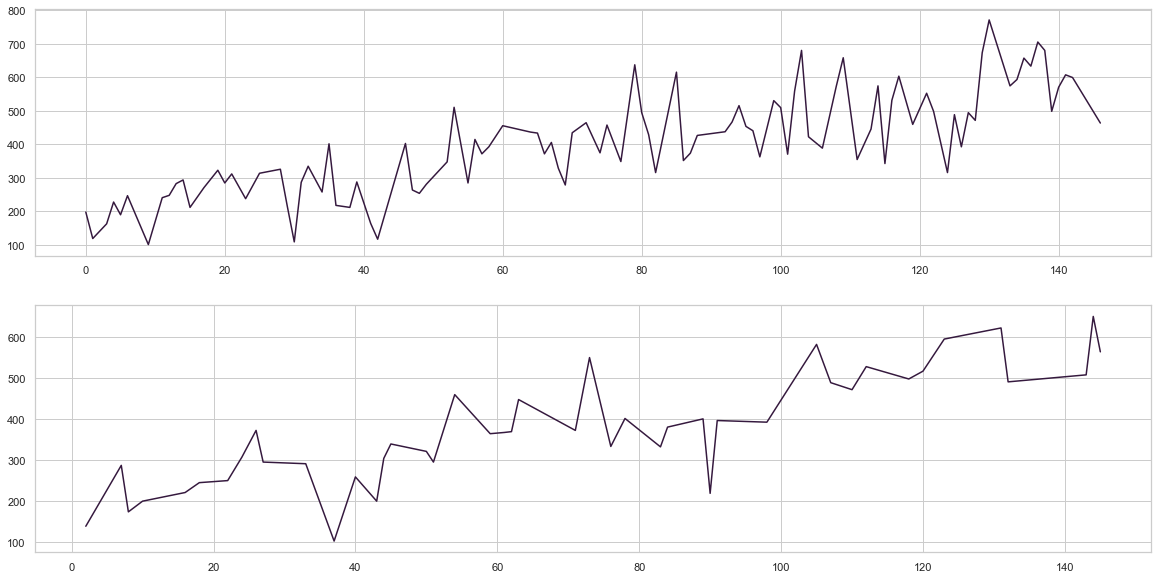

In [116]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.lineplot(data=y_train, ax=ax1)
sns.lineplot(data=y_test, ax=ax2)

In [159]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

## Model 1: Histogram Gradient Boosting regression

In [247]:
## Histogram gradient Boosting
histgrad = HistGradientBoostingRegressor(max_iter=72).fit(X_train, y_train)

# prediction on test data
y_pred_histgrad = histgrad.predict(X_test)

# evaluate
r2_histgrad = r2_score(y_test, y_pred_histgrad)
MAE_histgrad =  mean_absolute_error(y_test, y_pred_histgrad)
MSE_histgrad = mean_squared_error(y_test, y_pred_histgrad, squared = True)
RMSE_histgrad = mean_squared_error(y_test, y_pred_histgrad, squared = False)

print (f'Histogram Gradient Boosting Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of histogram gradient boosting regression is: ', r2_histgrad)
print ('The MAE  of histogram gradient boosting regression is: ', MAE_histgrad)
print ('The MSE  of histogram gradient boosting regression is: ', MSE_histgrad)
print ('The RMSE of histogram gradient boosting regression is: ', RMSE_histgrad, "\n\n")

Histogram Gradient Boosting Regression, dayly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of histogram gradient boosting regression is:  0.7946195062576222
The MAE  of histogram gradient boosting regression is:  46.58957577279122
The MSE  of histogram gradient boosting regression is:  3592.3253279953715
The RMSE of histogram gradient boosting regression is:  59.93601027758998 




## Model 2: Gradient Boosting Regression

In [248]:
## Gradient Boosting
grad = GradientBoostingRegressor(n_estimators=10000, loss='ls').fit(X_train, y_train)

# prediction on test data
y_pred_grad  = grad.predict(X_test)

# evaluate
r2_grad = r2_score(y_test, y_pred_grad)
MAE_grad =  mean_absolute_error(y_test, y_pred_grad)
MSE_grad = mean_squared_error(y_test, y_pred_grad, squared = True)
RMSE_grad = mean_squared_error(y_test, y_pred_grad, squared = False)

print (f'Gradient Boosting Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of gradient boosting regression is: ', r2_grad)
print ('The MAE  of gradient boosting regression is: ', MAE_grad)
print ('The MSE  of gradient boosting regression is: ', MSE_grad)
print ('The RMSE of gradient boosting regression is: ', RMSE_grad)

Gradient Boosting Regression, dayly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of gradient boosting regression is:  0.8435585298139363
The MAE  of gradient boosting regression is:  36.5978758810014
The MSE  of gradient boosting regression is:  2736.329266026444
The RMSE of gradient boosting regression is:  52.30993467809384


In [223]:
def plot_results(predictions):
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(15, 40))

    for i in range(0,len(features)):
        axes[i].scatter(X_train[features[i]],y_train, marker='x', color='b')
        axes[i].scatter(X_test[features[i]],predictions, marker='x', color='r')
        axes[i].set_xlabel(features[i])
        axes[i].set_ylabel("Demand")
        axes[i].legend(["Training Set", 'Prediction Set'])

## Model 3: Linear regression

Linear Regression, dayly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of linear regression is:  0.8082731280324834
The MAE  of linear regression is:  43.31495963372973
The MSE  of linear regression is:  3353.508824894413
The RMSE of linear regression is:  57.90948821129758
Coefficients  [  59.8258273     1.41961918    6.87537021  -12.60051788 -276.99177718
  -93.03396665   67.58292148] 
Intercept  266.08420984480466


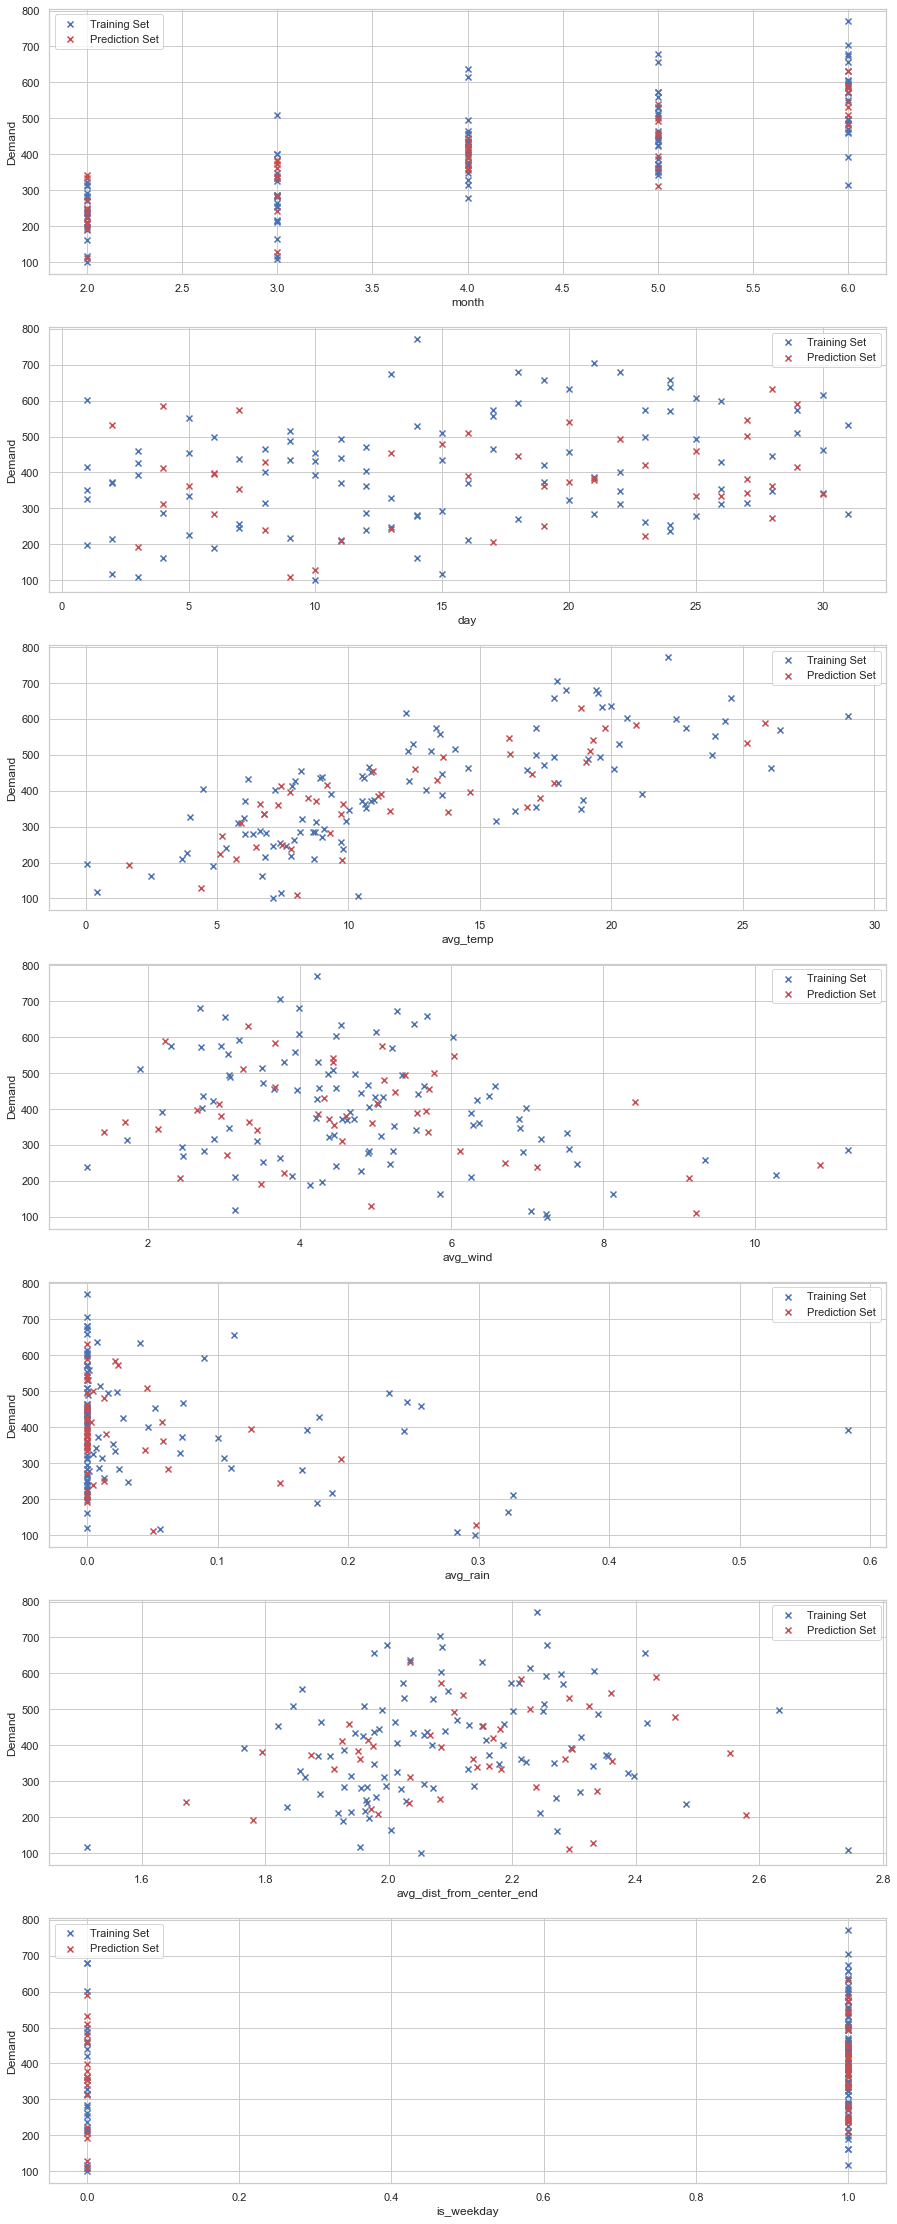

In [249]:
# fit model on training data
model_lin = LinearRegression(normalize = True)
model_lin.fit(X_train, y_train)

# prediction on test data
y_pred_lin = model_lin.predict(X_test)

# evaluate
r2_lin = r2_score(y_test, y_pred_lin)
MAE_lin =  mean_absolute_error(y_test, y_pred_lin)
MSE_lin = mean_squared_error(y_test, y_pred_lin, squared = True)
RMSE_lin = mean_squared_error(y_test, y_pred_lin, squared = False)

print (f'Linear Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of linear regression is: ', r2_lin)
print ('The MAE  of linear regression is: ', MAE_lin)
print ('The MSE  of linear regression is: ', MSE_lin)
print ('The RMSE of linear regression is: ', RMSE_lin)
print("Coefficients ", model_lin.coef_, "\nIntercept ", model_lin.intercept_ )
plot_results(y_pred_lin)

In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Model 4: polynomial regression

### select best degree via grid search and cross validation

In [209]:
# using grid search to find best degree by MAE
# https://scikit-learn.org/stable/modules/model_evaluation.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/grid_search.html
param_grid = [
    {'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8]}
  ]
  
pipeline_poly = Pipeline(steps=[('poly', PolynomialFeatures()), ('linear', LinearRegression(normalize = True))])
Poly_GS = GridSearchCV(pipeline_poly, param_grid, cv=5,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)
Poly_GS.fit(np.array(X_train).reshape(y_train.shape[0],-1), y_train)

poly2 = PolynomialFeatures(degree = Poly_GS.best_params_["poly__degree"])
x_poly2 = poly2.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
PolyRegression = LinearRegression(normalize = True)
PolyRegression.fit(x_poly2, y_train)

LinearRegression(normalize=True)

### evaluate model

Polynomial Regression, dayly, degree: 1
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of polynomial regression is:  0.8082731280324832
The MAE  of polynomial regression is:  43.314959633729735
The MSE  of polynomial regression is:  3353.508824894416
The RMSE of polynomial regression is:  57.90948821129761
Coefficients  [   0.           59.8258273     1.41961918    6.87537021  -12.60051788
 -276.99177718  -93.03396665   67.58292148] 
Intercept  266.08420984480523


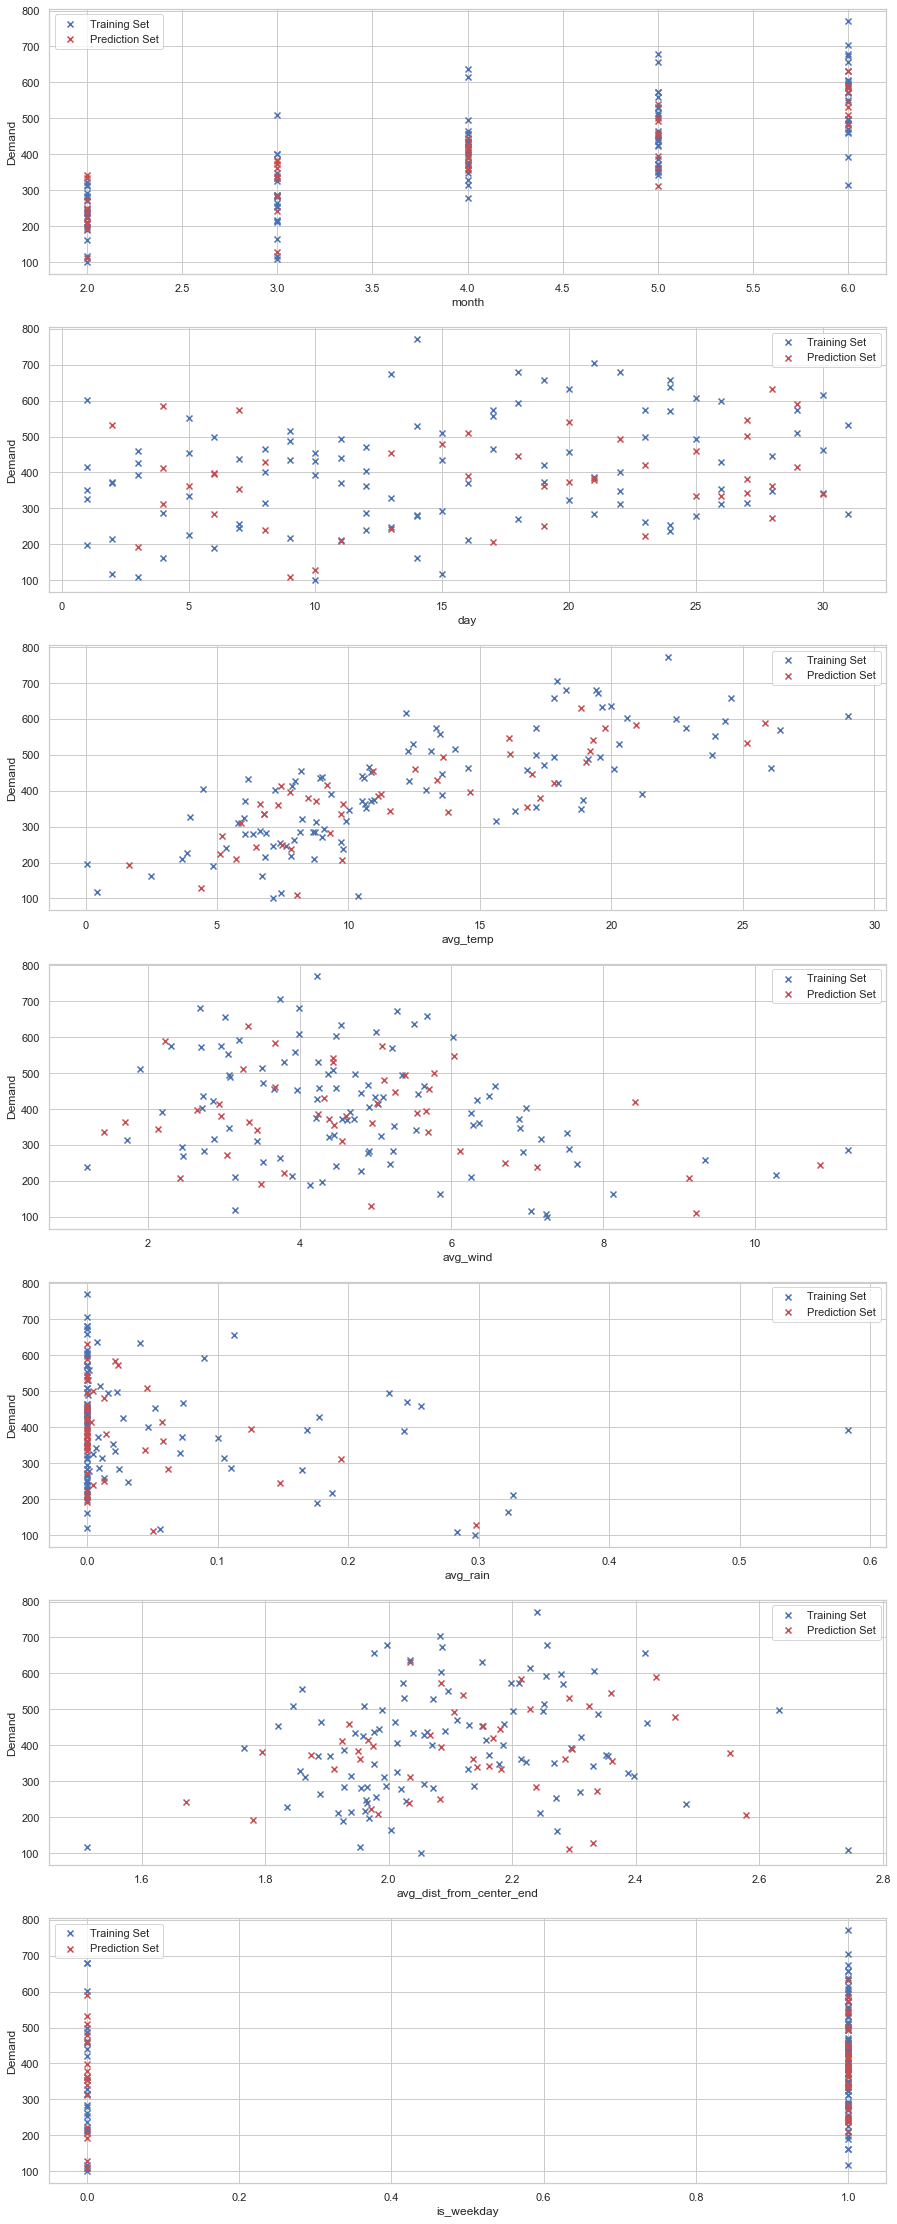

In [210]:
# prediction on test data
y_pred_poly = PolyRegression.predict(poly2.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_poly = r2_score(y_test, y_pred_poly)
MAE_poly =  mean_absolute_error(y_test, y_pred_poly)
MSE_poly = mean_squared_error(y_test, y_pred_poly, squared = True)
RMSE_poly = mean_squared_error(y_test, y_pred_poly, squared = False)

print (f'Polynomial Regression, {TIME_FRAME}ly, degree: {Poly_GS.best_params_["poly__degree"]}')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of polynomial regression is: ', r2_poly)
print ('The MAE  of polynomial regression is: ', MAE_poly)
print ('The MSE  of polynomial regression is: ', MSE_poly)
print ('The RMSE of polynomial regression is: ', RMSE_poly)
print("Coefficients ", PolyRegression.coef_, "\nIntercept ", PolyRegression.intercept_ )
plot_results(y_pred_poly)

## Model 5: Ridge regression

In [185]:
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer

### select best params via grid search and cross validation
Since the optimum degree seems to be 1 (=no polynomial features) we try to optimize by regularization parameter and solver

In [225]:
ridge = Ridge()
params_Ridge = {'alpha': [1,0.2, 0.15, 0.13, 0.11, 0.1,0.01,0.001,0.0001,0], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
Ridge_GS = GridSearchCV(ridge, param_grid=params_Ridge, n_jobs=-1, cv=5)
Ridge_GS.fit(X_train,y_train)
Ridgeregression = Ridge(random_state=0, **Ridge_GS.best_params_, normalize=True)
Ridgeregression.fit(X_train,y_train)

Ridge(alpha=0.11, normalize=True, random_state=0, solver='sag')

### evaluate model

Ridge Regression, dayly
Params:  {'alpha': 0.11, 'solver': 'sag'}
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_distance', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of ridge regression is:  0.8146190291037787
The MAE  of ridge regression is:  42.97684872716695
The MSE  of ridge regression is:  3242.512202323419
The RMSE of ridge regression is:  56.94306105508747
Coefficients  [  51.84024049    1.30466748    7.34900545  -11.98383282 -248.2209282
  -74.27051732   62.07387301] 
Intercept  255.25872309491993


KeyError: 'avg_distance'

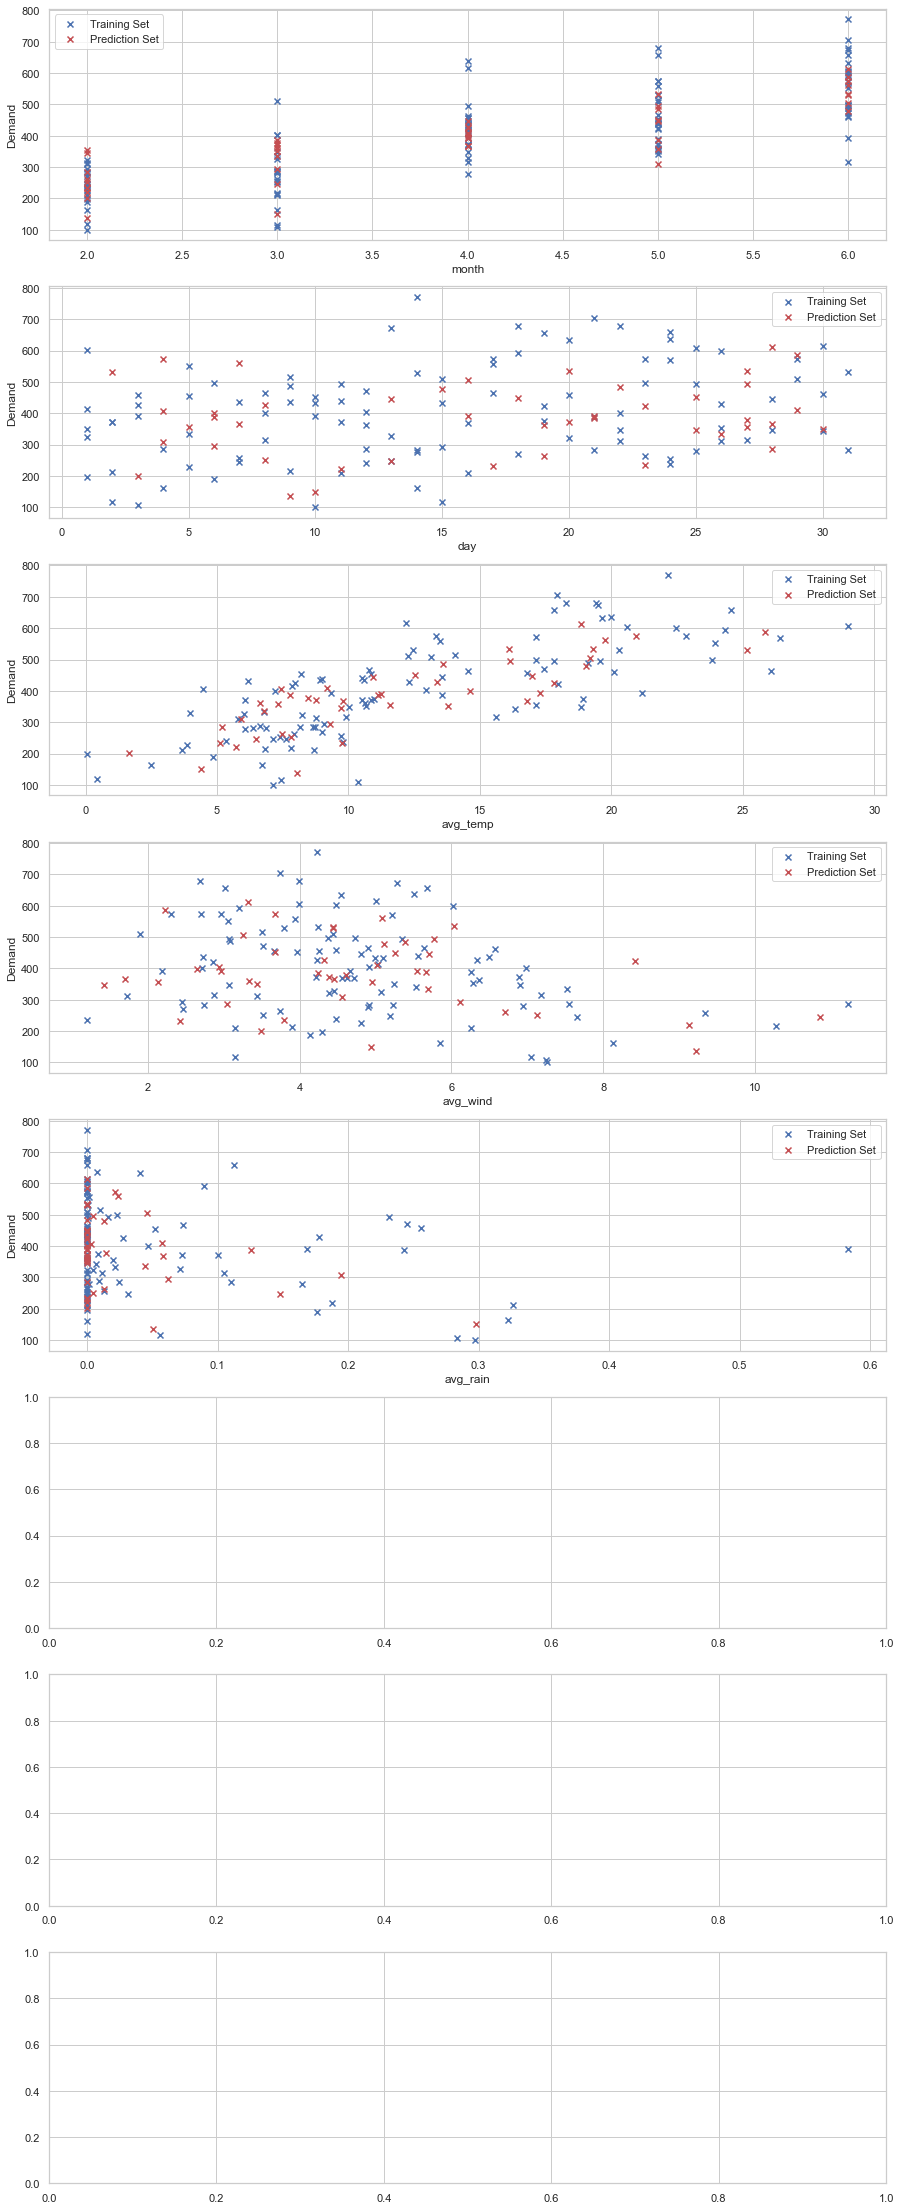

In [226]:
# prediction on test data
y_pred_ridge = Ridgeregression.predict(np.array(X_test).reshape(y_test.shape[0],-1))

# evaluate
r2_ridge = r2_score(y_test, y_pred_ridge)
MAE_ridge =  mean_absolute_error(y_test, y_pred_ridge)
MSE_ridge = mean_squared_error(y_test, y_pred_ridge, squared = True)
RMSE_ridge = mean_squared_error(y_test, y_pred_ridge, squared = False)

print (f'Ridge Regression, {TIME_FRAME}ly')
print('Params: ', Ridge_GS.best_params_)
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of ridge regression is: ', r2_ridge)
print ('The MAE  of ridge regression is: ', MAE_ridge)
print ('The MSE  of ridge regression is: ', MSE_ridge)
print ('The RMSE of ridge regression is: ', RMSE_ridge)
print("Coefficients ", Ridgeregression.coef_, "\nIntercept ", Ridgeregression.intercept_ )
plot_results(y_pred_ridge)

## Model 6: Lasso regression

In [188]:
from sklearn.linear_model import Lasso

### select best degree via grid search and cross validation
Since the optimum degree seems to be 1 (=no polynomial features) we try to optimize by regularization parameter, normalization and solver

In [189]:
lasso = Lasso()
params_lasso = {'alpha': [1,0.2, 0.15, 0.13, 0.11, 0.1,0.01,0.001,0.0001,0], 'normalize':[True,False], 'max_iter':[50, 70, 85, 100,200,300,400,500,1000,5000]}
Lasso_GS = GridSearchCV(lasso, param_grid=params_lasso, n_jobs=-1, cv=5)
Lasso_GS.fit(X_train,y_train)
Lassoregression = Lasso(random_state=0, **Lasso_GS.best_params_)
Lassoregression.fit(X_train,y_train)

Lasso(alpha=0.2, max_iter=50, normalize=True, random_state=0)

### evaluate model

Lasso Regression, dayly
Params:  {'alpha': 0.2, 'max_iter': 50, 'normalize': True}
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']
The R^2  of lasso regression is:  0.7099663725152348
The MAE  of lasso regression is:  53.7012711022873
The MSE  of lasso regression is:  5800.409012967119
The RMSE of lasso regression is:  76.16041631298452
Coefficients  [ 3.62273169e+01  1.70835855e-02  1.00799585e+01 -9.05758990e-01
 -4.36746132e+01  6.94261997e+00  0.00000000e+00] 
Intercept  -173.09733625886622


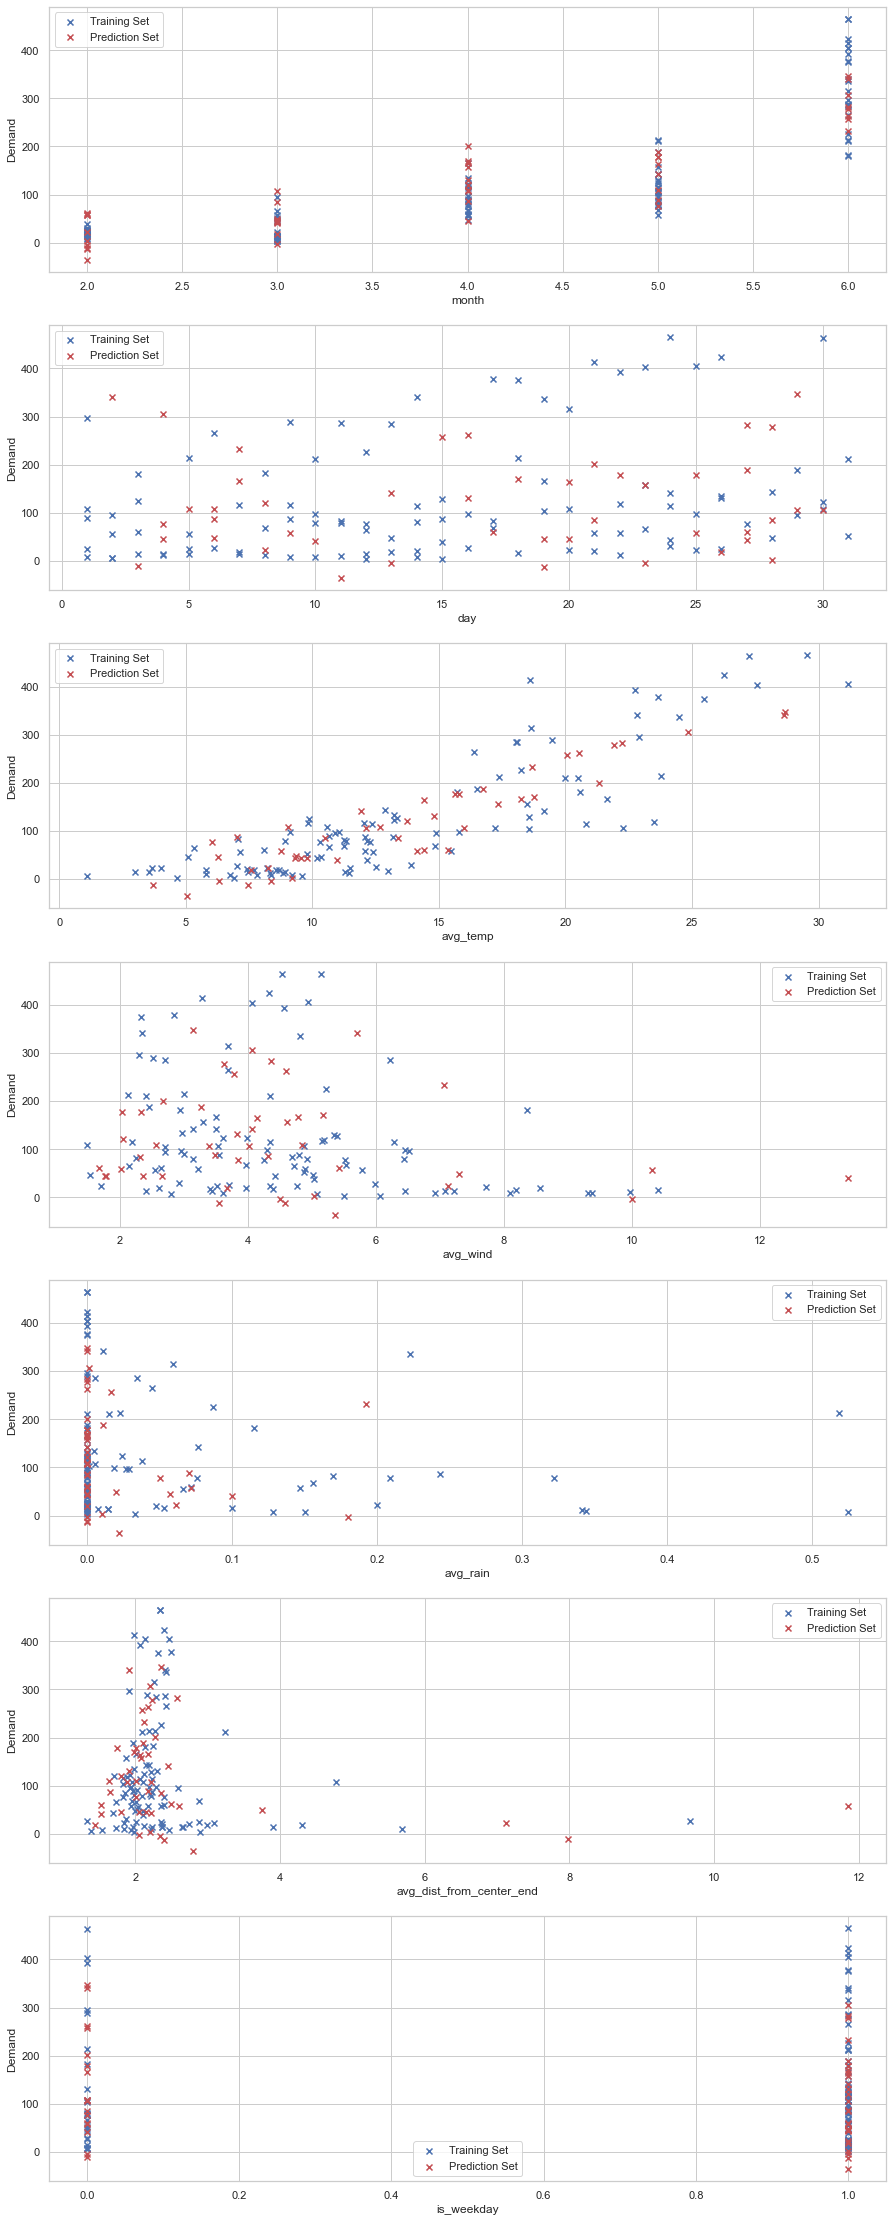

In [190]:
# prediction on test data
y_pred_lasso = Lassoregression.predict(np.array(X_test).reshape(y_test.shape[0],-1))

# evaluate
r2_lasso = r2_score(y_test, y_pred_lasso)
MAE_lasso=  mean_absolute_error(y_test, y_pred_lasso)
MSE_lasso = mean_squared_error(y_test, y_pred_lasso, squared = True)
RMSE_lasso = mean_squared_error(y_test, y_pred_lasso, squared = False)

print (f'Lasso Regression, {TIME_FRAME}ly')
print('Params: ', Lasso_GS.best_params_)
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of lasso regression is: ', r2_lasso)
print ('The MAE  of lasso regression is: ', MAE_lasso)
print ('The MSE  of lasso regression is: ', MSE_lasso)
print ('The RMSE of lasso regression is: ', RMSE_lasso)
print("Coefficients ", Lassoregression.coef_, "\nIntercept ", Lassoregression.intercept_ )
plot_results(y_pred_lasso)

***
# Results for daily demand prediction, Bremen

## Three Best Prediction models:
### Gradient Boosting Regression
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']


- The R^2  of gradient boosting regression is:  0.8415142205366798
- The MAE  of gradient boosting regression is:  36.821944055490086
- The MSE  of gradient boosting regression is:  2772.0864300157195
- The RMSE of gradient boosting regression is:  52.65060711915599

### Lasso regression
- Params:  {'alpha': 1, 'max_iter': 50, 'normalize': False}
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']


- The R^2  of lasso regression is:  0.815367412986413
- The MAE  of lasso regression is:  43.080802351128035
- The MSE  of lasso regression is:  3229.4221647659897
- The RMSE of lasso regression is:  56.82800510985749
- Coefficients  [  59.55078823    1.69723098    6.30426559  -13.29360202 -158.89821512
  -51.84380392   65.60881525] 
- Intercept  182.98523630301617

### Ridge regression
- Params:  {'alpha': 0.1, 'solver': 'sag'}
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']


- The R^2  of ridge regression is:  0.8146774422058534
- The MAE  of ridge regression is:  42.90088729513273
- The MSE  of ridge regression is:  3241.49049445698
- The RMSE of ridge regression is:  56.93408903685893
- Coefficients  [  52.38667653    1.30737866    7.34336608  -12.04044816 -250.48286644
  -75.92727537   62.50233722] 
- Intercept  256.5683428915413

***
# Results for daily demand prediction, Düsseldorf
## Three Best Prediction models:
### Gradient Boosting Regression
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']


- The R^2  of gradient boosting regression is:  0.9267427278467849
- The MAE  of gradient boosting regression is:  26.23107237486852
- The MSE  of gradient boosting regression is:  1465.0788784318263
- The RMSE of gradient boosting regression is:  38.27634881270451

### Histogram gradient boosting regression
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']


- The R^2  of histogram gradient boosting regression is:  0.8696700829729427
- The MAE  of histogram gradient boosting regression is:  32.03410734318198
- The MSE  of histogram gradient boosting regression is:  2606.479917307898
- The RMSE of histogram gradient boosting regression is:  51.05369641179665 

### Linear / polynomial regression (same, since degree=1)
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday']


- The R^2  of linear regression is:  0.7197471717618245
- The MAE  of linear regression is:  53.36802600764945
- The MSE  of linear regression is:  5604.8019152800725
- The RMSE of linear regression is:  74.86522500654141
- Coefficients  [ 38.35969494   0.3025595    9.88879856  -1.42774359 -61.15914775
  10.18895574  -0.66517261] 
- Intercept  -187.49086314384994

## General explanation of results, exemplary for Bremen
The best prediction model in Bremen, using gradient boosting regression, yielded an r^2 score of roughly 84,15%, which means that the model could explain or predict about 84,15% of the data variance correctly. The Mean Absolute Error of 36.82 Units indicates that the model could predict daily bike rental demand with a mean deviation of +- 36.82 rentals. The RMSE of 52.65 Units indicates that there are some higher deviations of predicted rental demand when compared to the MAE of 45.81. Higher deviations are obviously undesirable, but due to the highly variable nature of bike rental demand we assume the model performance to be bound by the provided data, which also contains high deviations.

## Implications
As the correlation analyis and prediction results suggest, we found evidence for some fairly obvious, but mostly anecdotal statements:
- The bike rental demand rises as the temperature increases, which can be observed when summer months are approached
- The hour of day matters for predicting the demand, since there are peak rental times (morning and afternoon hours), as well as lower rental demand in dark/night hours
- The weather is highly influencing bike rental demand, with rain and wind reducing the number of rented bikes
- The number of bike rentals is higher in the inner city
- The bike rental demand varies between weekdays and weekends

Based on this evidence, nextBike can optimize its service, especially the size of operating fleet, by incorporating said factors into their calculations. That could mean they set up a higher number of stations in the inner city, or try to increase their fleet size dramatically when the summer months are approaching. Another approach could be to react on weather forecast, because a drought could be accompanied by increased rental demand. Also the variance of demand between distinct hours of day and between weekdays and weekends open up opportunities to adjust their fleet dynamically, reducing the operation cost to the minimum.

## Possible Improvement 
The most important and promising improvement lever for future projects is a more detailed and dedicated selection of features. The comparison with hourly prediction suggests that a thorough analysis of weather data resulting in categorical weather features could yield even better results.

Another improvement lever could be the usage of holiday, event and natural event data, e.g. national holidays, soccer games to reduce the daily variance or to better predict high deviations from the mean demand.



***
# Results for daily demand prediction, Düsseldorf

## Three Best Prediction models:
### Gradient boosting regression
For training and test splits of 95% and 5%,  and features ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday'] it yielded following results: 
- The R^2  of gradient boosting regression is:  **0.9701379868229771**
- The MAE  of gradient boosting regression is:  **18.386961555600962**
- The MSE  of gradient boosting regression is:  757.905359936134
- The RMSE of gradient boosting regression is:  **27.530081001263582**

### Histogram gradient boosting regression
For training and test splits of 95% and 5%,  and features ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday'] it yielded following results: 
- The R^2  of histogram gradient boosting regression is:  0.9472127738996843
- The MAE  of histogram gradient boosting regression is:  29.726585936582556
- The MSE  of histogram gradient boosting regression is:  1339.7529952325372
- The RMSE of histogram gradient boosting regression is:  36.602636451935226 

### Lasso Regression
For training and test splits of 95% and 5%, polynomial degree of 4, lambda=0.1 and features ['month', 'day', 'avg_temp', 'avg_wind', 'avg_rain', 'avg_dist_from_center_end', 'is_weekday'] it yielded following results: 
- The R^2  of lasso regression is:  0.9437953775550606
- The MAE  of lasso regression is:  21.110861895117093
- The MSE  of lasso regression is:  1426.487368808174
- The RMSE of lasso regression is:  37.76886771943493

## General explanation of results
The best prediction model, using gradient boosting regression, yielded an r^2 score of roughly 97%, which means that the model could explain or predict most of the provided data and its variance correctly. The Mean Absolute Error of 18,38 Units indicates that the model could predict daily bike rental demand with a mean deviation of +- 18,38 rentals. The MSE of 757,9 Units and RMSE of 27,5 Units indicate that there are some higher deviations of predicted rental demand when compared to the MAE of 18,38. Higher deviations are obviously undesirable, but due to the highly variable nature of bike rental demand we assume the model performance to be bound by the provided data, which also contains high deviations.
However, the performance of the models for Düsseldorf is significantly higher than for Bremen, which might be due to the fact that there is a more monotonous trend for the data in Düsseldorf.

## Implications
As the correlation analyis and prediction results suggest, we found evidence for some fairly obvious, but mostly anecdotal statements:
- The bike rental demand rises as the temperature increases, which can be observed when summer months are approached
- The hour of day matters for predicting the demand, since there are peak rental times (morning and afternoon hours), as well as lower rental demand in dark/night hours
- The weather is highly influencing bike rental demand, with rain and wind reducing the number of rented bikes
- The number of bike rentals is higher in the inner city
- The bike rental demand varies between weekdays and weekends

Based on this evidence, nextBike can optimize its service, especially the size of operating fleet, by incorporating said factors into their calculations. That could mean they set up a higher number of stations in the inner city, or try to increase their fleet size dramatically when the summer months are approaching. Another approach could be to react on weather forecast, because a drought could be accompanied by increased rental demand. Also the variance of demand between distinct hours of day and between weekdays and weekends open up opportunities to adjust their fleet dynamically, reducing the operation cost to the minimum.

## Possible Improvement 
The most important and promising improvement lever for futre projects is a more detailed selection of features. The comparison of boosting regressors with the other regression types suggests that a thorough analysis of weather data resulting in categorical weather features could yield even better results. As the boosting regressors have shown similar or worse results in comparison to the other regression types (polynomial, ridge, lasso) on the same features, including continuous weather data, they are comparably better when using simple categorical weather features indicating bad weather (is_windy, is_rainy).

Another improvement lever could be the usage of holiday, event and natural event data, e.g. national holidays, soccer games to reduce the daily variance or to better predict high deviations from the mean demand.